Compare grid geometry at the mouth of v93 and v100, trying to understand why tides appear to be more muted in v100, while the bathy should be deeper.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import six

import numpy as np
import xarray as xr
import pandas as pd
import os

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
from stompy import utils
import pesca_base

INFO:DFlowModel:DelwaqScalarBC instantiated.


In [2]:
%matplotlib notebook

In [3]:
# Load QCM data, too -- code taken from pesca_base.py
qcm_pre2016=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output.csv",                                                                     
                        skiprows=[0],usecols=range(7),                                                                                              
                        parse_dates=['Date (PST)'])                                                                                                 
qcm_2016_2017=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output_4.28.2021.csv",                                                         
                          skiprows=[0],usecols=range(14),                                                                                           
                          parse_dates=['Date (PST)'])                                                                                               
# some extra rows in the csv                                                                                                                        
qcm_2016_2017=qcm_2016_2017[ ~qcm_2016_2017['Date (PST)'].isnull() ]                                                                                
qcm=pd.concat([qcm_pre2016,qcm_2016_2017])                                                                                                          

qcm['time']=qcm['Date (PST)'] + np.timedelta64(8,'h') # Shift to UTC.                                                        
# These are both NAVD88, converted ft=>m                                                                                                            
# Prefer the modified data when available:                                                                                                          
ocean_modified=qcm['Modified Ocean Level (feet NAVD88)']                                                                                            
# Otherwise the observed data.                                                                                                                      
ocean_level=qcm['Ocean level (feet NAVD88)']                                                                                                        
qcm['z_ocean']=0.3048 * ocean_modified.combine_first(ocean_level)
qcm['z_ocean_orig']=0.3048 * ocean_level

qcm['z_thalweg']=0.3048 * qcm['Modeled Inlet thalweg elevation (feet NAVD88)']                                                                      
# width                                                                                                                                             
qcm['w_inlet']=0.3048* qcm['Modeled Inlet Width (feet)']                                                                                            

qcm_ds=xr.Dataset.from_dataframe(qcm[ ['time','z_ocean',
                                       'z_ocean_orig','z_thalweg','w_inlet']
                                    ].set_index('time')) 

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
bml_nck_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_sfc_mcat_concatenated.csv")
bml_nck_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_btm_mcat_concatenated.csv")
bml_nck_wll     =pd.read_csv("../../data/BML data/2016/all_concatenated/csv/NCK_wll_concatenated.csv")
bml_nck_wll['depth m'] -= 10.406 # based on comparison to QCM

bml_pc3_sfc_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_sfc_sonde_concatenated.csv")
bml_pc3_btm_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_btm_sonde_concatenated.csv")
bml_pc3_wll     =pd.read_csv("../../data/BML data/2016/all_concatenated/csv/PC3_wll_concatenated.csv")

bml_bc1_btm_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC1_btm_sonde_concatenated.csv")
bml_bc1_sfc_sond=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC1_sfc_sonde_concatenated.csv")
bml_bc1_wll     =pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC1_wll_concatenated.csv")

bml_bc3_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC3_btm_mcat_concatenated.csv")
bml_bc3_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC3_sfc_mcat_concatenated.csv")
bml_bc3_wll     =pd.read_csv("../../data/BML data/2016/all_concatenated/csv/BC3_wll_concatenated.csv")

bml_ch2_btm_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/CH2_btm_mcat_concatenated.csv")
bml_ch2_sfc_mcat=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/CH2_sfc_mcat_concatenated.csv")
bml_ch2_wll     =pd.read_csv("../../data/BML data/2016/all_concatenated/csv/CH2_wll_concatenated.csv")

for df in [bml_nck_sfc_mcat,
           bml_nck_btm_mcat,
           bml_nck_wll,
           
           bml_pc3_sfc_sond,
           bml_pc3_btm_sond,
           bml_pc3_wll,
           
           bml_bc1_btm_sond,
           bml_bc1_sfc_sond,
           bml_bc1_wll,
           
           bml_bc3_btm_mcat,
           bml_bc3_sfc_mcat,
           bml_bc3_wll,
           
           bml_ch2_btm_mcat,
           bml_ch2_sfc_mcat,
           bml_ch2_wll,           
]:
    # UTC
    df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
    df.set_index('time',inplace=True)

<xarray.Dataset>
Dimensions:                                  (cross_section: 10, gategens: 3, general_structures: 2, laydim: 28, laydimw: 29, nFlowElemContourPts: 4, nFlowElemWithBnd: 5705, nFlowLink: 8832, nFlowLinkPts: 2, nNetLink: 9154, nNetLinkPts: 2, station_geom_nNodes: 15, stations: 15, time: 4411)
Coordinates:
    station_x_coordinate                     (stations) float64 5.526e+05 ......
    station_y_coordinate                     (stations) float64 4.124e+06 ......
    station_name                             (stations) |S64 b'pch_up' ... b'...
    zcoordinate_c                            (time, stations, laydim) float64 ...
    zcoordinate_w                            (time, stations, laydimw) float64 ...
    zcoordinate_wu                           (time, stations, laydimw) float64 ...
    cross_section_name                       (cross_section) |S64 b'mouth_xs'...
    general_structure_id                     (general_structures) |S64 b'mout...
    gategen_name                             (gategens) |S64 b'pch_gate' ... ...
  * time                                     (time) datetime64[ns] 2016-06-10...
    run                                      <U4 'v100'
Dimensions without coordinates: cross_section, gategens, general_structures, laydim, laydimw, nFlowElemContourPts, nFlowElemWithBnd, nFlowLink, nFlowLinkPts, nNetLink, nNetLinkPts, station_geom_nNodes, stations
Data variables:
    FlowElem_xcc                             (nFlowElemWithBnd) float64 5.526...
    FlowElem_ycc                             (nFlowElemWithBnd) float64 4.123...
    FlowElem_zcc                             (nFlowElemWithBnd) float64 -1.27...
    FlowElem_bac                             (nFlowElemWithBnd) float64 21.54...
    FlowElem_xzw                             (nFlowElemWithBnd) float64 5.526...
    FlowElem_yzw                             (nFlowElemWithBnd) float64 4.123...
    FlowElemContour_x                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElemContour_y                        (nFlowElemWithBnd, nFlowElemContourPts) float64 ...
    FlowElem_bl                              (nFlowElemWithBnd) float64 1.27 ...
    ElemLink                                 (nNetLink, nNetLinkPts) int32 1 ...
    FlowLink                                 (nFlowLink, nFlowLinkPts) int32 ...
    FlowLinkType                             (nFlowLink) int32 2 2 2 2 ... 2 2 2
    FlowLink_xu                              (nFlowLink) float64 5.526e+05 .....
    FlowLink_yu                              (nFlowLink) float64 4.123e+06 .....
    projected_coordinate_system              int32 -2147483647
    FlowLink_lonu                            (nFlowLink) float64 9.969e+36 .....
    FlowLink_latu                            (nFlowLink) float64 9.969e+36 .....
    FlowElemDomain                           (nFlowElemWithBnd) int32 5 5 ... 7
    FlowLinkDomain                           (nFlowLink) int32 0 0 0 0 ... 0 0 0
    FlowElemGlobalNr                         (nFlowElemWithBnd) int32 62511 ....
    station_id                               (stations) |S64 b'pch_up' ... b'...
    station_geom                             int32 -2147483647
    station_geom_node_count                  (stations) int32 1 1 1 1 ... 1 1 1
    station_geom_node_coordx                 (station_geom_nNodes) float64 5....
    station_geom_node_coordy                 (station_geom_nNodes) float64 4....
    waterlevel                               (time, stations) float64 1.353 ....
    bedlevel                                 (stations) float64 0.7396 ... 0.283
    x_velocity                               (time, stations, laydim) float64 ...
    y_velocity                               (time, stations, laydim) float64 ...
    z_velocity                               (time, stations, laydim) float64 ...
    depth-averaged_x_velocity                (time, stations) float64 0.0 ......
    depth-averaged_y_velocity                (time, stations) float64 0.0

In [41]:
his100_ds=(xr.open_dataset("run_salt_20160520-v100/DFM_OUTPUT_flowfm/flowfm_0000_his.nc")
    .assign_coords(run='v100')).isel(time=slice(0,-3))
his93_ds =(xr.open_dataset("run_salt_20160520-v93/DFM_OUTPUT_flowfm/flowfm_0000_his.nc")
    .assign_coords(run='v93'))
hiss=[his100_ds,his93_ds]

In [42]:
stn_name='nck'
stns=[ (his.isel(stations=[s.decode()
                          for s in hiss[0].station_name.values]
                 .index(stn_name)))
       for his in hiss]

<IPython.core.display.Javascript object>


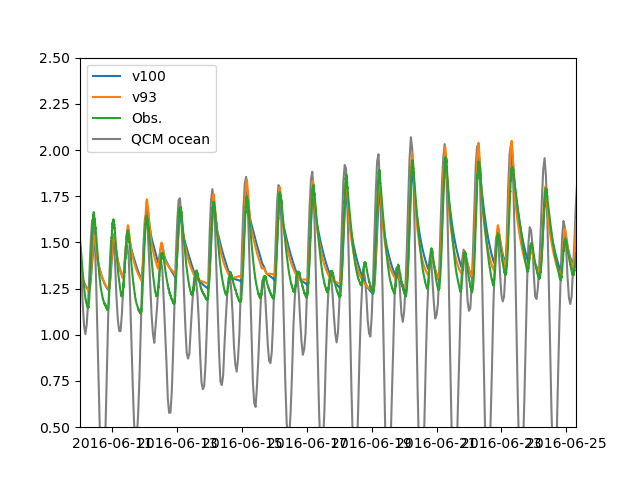

In [43]:
fig,ax=plt.subplots()

for stn in stns:
    ax.plot(stn.time, stn.waterlevel, label=stn.run.values)
    
ax.plot(bml_nck_wll.index.values,bml_nck_wll['depth m'],label='Obs.')

ax.plot(qcm.time, qcm.z_ocean,label='QCM ocean',zorder=-1,color='0.5')
ax.axis(ymin=0.5, ymax=2.5,
       xmin=hiss[0].time.values.min(),
       xmax=hiss[0].time.values.max())

plt.legend()

In [44]:
xs_name='mouth_xs'
xss=[ (his.isel(cross_section=[s.decode()
                               for s in hiss[0].cross_section_name.values]
                 .index(xs_name)))
       for his in hiss]

<IPython.core.display.Javascript object>


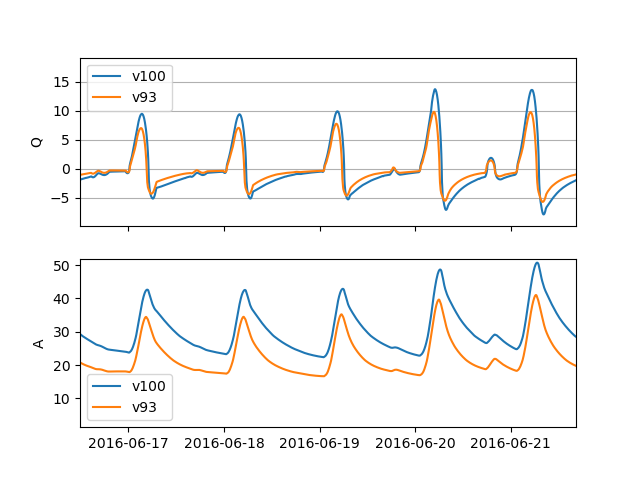

(16960.475520833334, 16994.0140625, -0.5, 50.0)

In [45]:
fig,axs=plt.subplots(2,1,sharex=True)

for xs in xss:
    axs[0].plot(xs.time,xs.cross_section_discharge,label=xs.run.values)
    axs[1].plot(xs.time,xs.cross_section_area,label=xs.run.values)

axs[0].set_ylabel('Q')
axs[1].set_ylabel('A')
axs[0].legend()
axs[1].legend()

axs[0].axis(ymin=-10,ymax=10)
axs[1].axis(ymin=-0.5,ymax=50)